In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.individual import get_individual_model
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_weights_magnitude = os.path.join('svg', 'figureS14a_weights_magnitude.svg')
path_figure_weights_correlation = os.path.join('svg', 'figureS14a_weights_correlation.svg')
path_model_individual = os.path.join('..', '..', 'results', 'individual')

In [4]:
num_runs = 10
initial_seed = 1234
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 41080
num_test = 8216
tasks_names = ['vowel', 'position']

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_individual, parameters)

Found simulation in ../../results/individual with the same parameters (2024-01-12_17-59-49)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [7]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[165158, 220532, 318129, 451283, 486191, 514041, 818831, 869016, 908341, 978124]
['vowel', 'position']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

## Plot All RDMs

In [9]:
tasks_datasets

{'vowel': Dataset VowelTask
     Number of datapoints: 49296
     Root location: ../../data
     Split: Train,
 'position': Dataset PositionTask
     Number of datapoints: 49296
     Root location: ../../data
     Split: Train}

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

biases = np.zeros((num_tasks, num_hidden[0], num_layers))
norm_biases = np.zeros((num_runs, num_tasks, num_layers))
correlations = np.zeros((num_runs, num_layers))

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_numbers = []
    indices = results_individual[seed]['indices']

    for i_bias in range(num_layers):
        for i_task, task_name in enumerate(tasks_names):
            state_dict = results_individual[seed][task_name]['model']

            model = get_individual_model(num_hidden,
                                        device)
            model.load_state_dict(state_dict)
            model.to(device)

            biases[i_task, :, i_bias] = model.layers[i_bias].bias.cpu().detach().numpy()
            norm_biases[i_seed, i_task, i_bias] = np.linalg.norm(biases[i_task, :, i_bias], axis=0)

        correlations[i_seed, i_bias] = np.corrcoef(biases[0, :, i_bias],
                                                      biases[1, :, i_bias])[0, 1]
    


Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

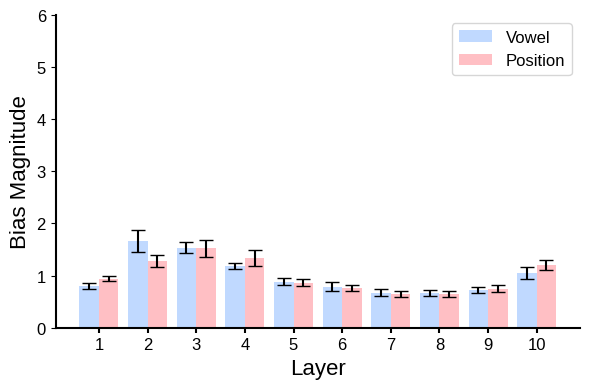

In [11]:
idxs_layers = np.arange(1, 11)

mean_parity = norm_biases.mean(axis=0)[0, :]
mean_value = norm_biases.mean(axis=0)[1, :]
std_parity = norm_biases.std(axis=0)[0, :]
std_value = norm_biases.std(axis=0)[1, :]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(idxs_layers-0.2, mean_parity, width=0.4, color=palette[0])
ax.bar(idxs_layers+0.2, mean_value, width=0.4, color=palette[-1])

ax.errorbar(idxs_layers-0.2, mean_parity, std_parity, color='k', linestyle='', capsize=5)
ax.errorbar(idxs_layers+0.2, mean_value, std_value, color='k', linestyle='', capsize=5)

ax.set_ylim(0, 6)
ax.set_xlabel('Layer')
ax.set_ylabel('Bias Magnitude')
ax.set_xticks(idxs_layers)

ax.legend(['Vowel', 'Position'])

fig.tight_layout()
fig.savefig(path_figure_weights_magnitude, transparent=True)

plt.show()

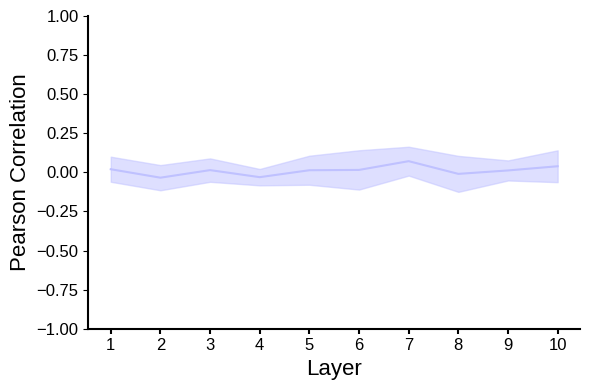

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

mean_corr = correlations.mean(axis=0)
std_corr = correlations.std(axis=0)

ax.plot(idxs_layers, mean_corr, color=palette[1])
ax.fill_between(idxs_layers, mean_corr-std_corr, mean_corr+std_corr, color=palette[1], alpha=.5)

ax.set_xlabel('Layer')
ax.set_ylabel('Pearson Correlation')
ax.set_xticks(idxs_layers)
ax.set_ylim(-1, 1)

fig.tight_layout()
fig.savefig(path_figure_weights_correlation, transparent=True)

plt.show()